In [2]:
import numpy as np
import networkx as nx
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, state_fidelity
from qiskit_experiments.library import StateTomography
from qclib.state_preparation import MixedInitialize, BaaLowRankInitialize
from qclib.state_preparation.util.baa import adaptive_approximation
from qclib.machine_learning.datasets import digits
from qclib.entanglement import schmidt_decomposition
from qclib.state_preparation.util.baa import _split_combinations
from qclib.util import get_cnot_count

# If you are not using the `qdna-lib` source code,
# comment out the following two lines.
import sys
sys.path.append('../../qdna-lib/')

from qdna.compression import SchmidtCompressor
from qdna.quantum_info import correlation_graph, \
                              concurrence, \
                              mutual_information, \
                              von_neumann_entropy, \
                              correlation


***
## Configuration
***

In [3]:
shots = 1024 * 8
backend_type = 'local' # local, local_noisy, cloud, cloud_device
calc_type = 'ideal' # ideal, tomography, quasi-probs
classes = [1]
training_size = 160
test_size = 10
n_qubits = 6
low_rank = 0
max_fidelity_loss = 0.0
baa_strategy = 'brute_force'
use_low_rank = False
partitioning_method = 'brute_force' # brute_force, graph
info_measure = mutual_information # concurrence, mutual_information, von_neumann_entropy

***
## Backend configuration
***

In [4]:
noise_model = None
coupling_map = None
basis_gates = None

if backend_type == 'cloud':
    # Cloud noiseless simulation
    from qiskit_ibm_provider import IBMProvider
    from qiskit.primitives import BackendSampler

    provider = IBMProvider(instance='ibm-q/open/main')
    backend  = provider.get_backend('ibmq_qasm_simulator')
    sampler = BackendSampler(
        backend=backend,
        options = {
            'shots' : shots
        }
    )

elif backend_type == 'cloud_device':
    # Cloud device
    from qiskit_ibm_provider import IBMProvider
    from qiskit.primitives import BackendSampler

    provider = IBMProvider(instance='ibm-q/open/main')
    backend  = provider.get_backend('ibm_osaka')
    sampler = BackendSampler(
        backend=backend,
        options = {
            'shots' : shots
        }
    )

elif backend_type == 'local_noisy':
    # Local noisy simulation
    from qiskit_aer import AerSimulator
    from qiskit.primitives import BackendSampler
    from qiskit.providers.fake_provider import FakeMumbai
    
    noisy_backend = FakeMumbai()
    
    backend = AerSimulator.from_backend(noisy_backend)
    sampler = BackendSampler(
        backend=backend,
        options = {
            'shots' : shots
        }
    )

else:
    # Local noiseless simulation
    from qiskit_aer import AerSimulator
    from qiskit.primitives import BackendSampler
    backend = AerSimulator(shots=shots)
    sampler = BackendSampler(
        backend=backend,
        options = {
            'shots' : shots
        }
    )

***
## Dataset
***

In [5]:
# Dataset load.
seed = 42

# Here you can choose the dataset classes. For example: [3], [0,1], [1,8], [2,4,7], etc.
sample_total, training_input, test_input, class_labels = digits.load(classes=classes,
                                                                     training_size=training_size,
                                                                     test_size=test_size,
                                                                     random_seed=seed,
                                                                     features=2**n_qubits)
feature_dim = len(training_input[class_labels[0]][0])
n_qubits = int(np.ceil(np.log2(feature_dim)))

# Variables to collect data for the summary.
fidelities = [[],[],[]]
figures = [[],[],[]]

In [6]:
# Prints information on training and test datasets.
for _, train_samples in training_input.items():
    print(train_samples.shape)
for _, test_samples in test_input.items():
    print(test_samples.shape)

(160, 64)
(10, 64)


***
## Experiment main routine
***

In [7]:
def calc_fidelity(state1, state2):
    bra = np.conj(state1)
    ket = state2

    return np.power(np.abs(bra.dot(ket)), 2)

def measurement(circuit, n_qubits, classical_register, backend, shots):
    """ run circuit and return measurements """
    circuit.measure(range(n_qubits), classical_register)

    result = sampler.run(circuit).result()

    counts = result.quasi_dists[0]

    counts2 = {}
    for k in range(2 ** n_qubits):
        if k in counts:
            counts2[k] = counts[k]
        else:
            counts2[k] = 0.0

    return np.array([value for (_, value) in counts2.items()])

def plot_digits(vectors, num_data_qubits, text=''):
    import matplotlib.pyplot as plt
    _dpi = 96
    matrix_dim_1 = 2**(int(np.ceil(num_data_qubits/2)))
    matrix_dim_2 = 2**(int(np.floor(num_data_qubits/2)))

    ncols = len(vectors)
    _, axes = plt.subplots(
        nrows=1,
        ncols=ncols,
        figsize=(
            ncols*10*matrix_dim_1/_dpi,
            10*matrix_dim_2/_dpi
        ),
        dpi=_dpi
    )
    for ax, vector in zip(axes, vectors):
        ax.set_axis_off()
        image = vector.reshape(matrix_dim_1, matrix_dim_2)
        ax.imshow(image, cmap=plt.cm.gray, interpolation='none')

    plt.show()

def calc_probabilities(circuit, test_sample):
    
    if calc_type == 'quasi-probs':
        c_reg = ClassicalRegister(n_qubits)
        circuit.add_register(c_reg)
        output_probs = measurement(circuit, n_qubits, c_reg, backend, shots)
        fidelity = calc_fidelity(test_sample, np.sqrt(output_probs))

    elif calc_type == 'tomography':
        st = StateTomography(
            circuit,
            measurement_indices=range(n_qubits)
        )
        st_data = st.run(
            backend,
            basis_gates=basis_gates,
            coupling_map=coupling_map,
            shots=shots
        ).block_for_results()
        state = st_data.analysis_results("state").value
        rho = DensityMatrix(state)
        sigma = DensityMatrix(test_sample, dims=2**n_qubits)
        fidelity = state_fidelity(sigma, rho)
        output_probs = rho.probabilities(range(n_qubits))

    else:
        # calc_type == 'ideal'
        rho = partial_trace(DensityMatrix(circuit), range(n_qubits, circuit.num_qubits))
        sigma = DensityMatrix(test_sample, dims=2**n_qubits)
        fidelity = state_fidelity(sigma, rho)
        output_probs = rho.probabilities()

    return output_probs, fidelity

# Creates an example of the circuit.
def complete_circuit(initializer, compressor, decompressor, reference=None):

    # Info about the auxiliary space.
    len_aux = 0
    len_reference = 0
    if reference is not None:
        len_aux = reference[0].num_qubits // 2
        len_reference = len(reference)

    n_trash_qubits = len(compressor.trash_qubits)
    n_aux_qubits = len_aux * len_reference

    # Creates the quantum circuit.
    circuit = QuantumCircuit(n_qubits + n_trash_qubits + n_aux_qubits)

    latent_qubits = np.array(compressor.latent_qubits)
    trash_qubits = np.array(range(n_qubits, n_qubits+n_trash_qubits))
    aux_qubits = np.array(range(n_qubits+n_trash_qubits, n_qubits + n_trash_qubits + n_aux_qubits))

    # Circuit on Alice's side.
    alice_register = np.array([None] * compressor.num_qubits)
    alice_register[compressor.trash_qubits] = trash_qubits[:]
    alice_register[compressor.latent_qubits] = latent_qubits[:]

    circuit.append(initializer.definition, [*alice_register])
    circuit.append(compressor.definition, [*alice_register])

    # Circuit on Bob's side.
    bob_register = list(range(n_qubits))

    if reference is not None:
        circuit.barrier()
        bob_trash_qubits = np.array(decompressor.trash_qubits)
        for i, ref_initializer in enumerate(reference):
            qubits_idx = list(range(i * len_aux, (i+1) * len_aux))
            circuit.compose(
                ref_initializer.definition,
                [*aux_qubits[qubits_idx], *bob_trash_qubits[qubits_idx]],
                inplace=True
            )
        circuit.barrier()
    circuit.append(decompressor.definition, bob_register)

    return circuit  

def experiment(test_input, compressor, decompressor, references=None, verbose=1):
    # Applies the compression-decompression process to each of the test samples.

    fidelities = []
    figures = []

    # Iterates through all test samples.
    for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
        reference = None
        if references is not None:
            reference = references[i]

        # initializer = StatePreparation(test_sample)
        initializer = BaaLowRankInitialize(
            test_sample,
            opt_params={
                'max_fidelity_loss': max_fidelity_loss,
                'strategy': baa_strategy,
                'use_low_rank': use_low_rank
            }
        )
        circuit = complete_circuit(initializer, compressor, decompressor, reference=reference)

        output_probs, fidelity = calc_probabilities(circuit, test_sample)

        # Calculates the approximate state vector
        node = adaptive_approximation(
            test_sample,
            max_fidelity_loss=max_fidelity_loss,
            strategy=baa_strategy,
            use_low_rank=use_low_rank
        )

        # Stores and prints the results.
        fidelities.append(fidelity)
        figures.append([np.abs(test_sample)**2, np.abs(node.state_vector())**2, output_probs])
        if verbose > 0:
            print(i, '- Recovered state fidelity =', fidelity)
        if verbose > 1:
            plot_digits([np.abs(test_sample)**2, np.abs(node.state_vector())**2, output_probs], n_qubits)

    return fidelities, figures

***
## Calculates the typical state
***

In [8]:
# Estimate the centroid.
# Simply the average of the training samples (or a random selection of samples).

centroid = np.zeros(2**n_qubits)
for train_sample in np.concatenate([train_samples for _, train_samples in training_input.items()]):
    # Calculates the approximate state vector
    node = adaptive_approximation(
        train_sample,
        max_fidelity_loss=max_fidelity_loss,
        strategy=baa_strategy,
        use_low_rank=use_low_rank
    )
    centroid += node.state_vector()

typical_state = centroid / np.linalg.norm(centroid)

print(typical_state.shape)

(64,)


***
## Find the best partitioning configuration.
***

In [9]:
# Defines the number of latent qubits.
# `0 < n_latent_partition < n_qubits`.
n_latent_partition = n_qubits // 2
n_trash_partition = n_qubits - n_latent_partition

In [10]:
if partitioning_method == 'graph':
    graph = correlation_graph(typical_state, n_qubits, max_set_size=1, correlation_measure=info_measure)
    nodes = list(graph.nodes())

    # Off-the-shelf algorithm for finding the best bipartition.
    (set_a, set_b) = nx.community.kernighan_lin_bisection(
        graph,
        (nodes[:n_latent_partition], nodes[n_latent_partition:]),
        weight='weight'
    )

    # Flatten the results.
    flat_set_a = set([item for sublist in set_a for item in sublist if len(sublist)==1])
    flat_set_b = set([item for sublist in set_b for item in sublist if len(sublist)==1])

    latent_partition = sorted(flat_set_a)
    trash_partition = sorted(flat_set_b)

    # Calculate the sum of weights of edges between the two sets
    cut_weight = sum(
        graph[u][v]['weight'] for u in set_a for v in set_b if graph.has_edge(u, v)
    )
    print('cut_weight', cut_weight)

    # Draw graph result
    cut_edges = [(u, v) for u, v in graph.edges if (u in set_a and v in set_b) or (u in set_b and v in set_a)]
    uncut_edges = [(u, v) for u, v in graph.edges if (u in set_a and v in set_a) or (u in set_b and v in set_b)]

    pos = nx.shell_layout(graph)
    nx.draw_networkx_nodes(graph, pos, nodelist=set_a, node_color='r')
    nx.draw_networkx_nodes(graph, pos, nodelist=set_b, node_color='c')
    nx.draw_networkx_edges(graph, pos, edgelist=cut_edges, style='dashdot', alpha=0.25, width=3)
    nx.draw_networkx_edges(graph, pos, edgelist=uncut_edges, style='solid', width=3)
    nx.draw_networkx_labels(graph, pos)
else:
    # partitioning_method == 'brute_force'

    def vn_entropy(singular_values):
        '''
        Calculates the entropy using the singular values.
        '''
        squared_singular_values = np.power([s for s in singular_values if s >= 1e-17], 2)
        return -np.sum(squared_singular_values * np.log(squared_singular_values))

    # Set `min_entropy` equal to the maximum entropy for the system.
    min_entropy = vn_entropy(
        [1/np.sqrt(2**n_trash_partition)] * 2**n_trash_partition
    )

    for partition in _split_combinations(range(n_qubits), n_trash_partition):
        rank, svd_u, singular_values, svd_v = schmidt_decomposition(
            typical_state, partition, rank=0, svd='auto'
        )

        entropy = vn_entropy(singular_values)

        print('partition', partition, 'entropy', entropy)
        if entropy <= min_entropy:
            min_entropy = entropy
            trash_partition = partition
            latent_partition = sorted(set(range(n_qubits)).difference(set(trash_partition)))

    print('min_entropy', min_entropy)

partition (0, 1, 2) entropy 0.0974419207230959
partition (0, 1, 3) entropy 0.7685015170928456
partition (0, 1, 4) entropy 0.7618424639605473
partition (0, 1, 5) entropy 0.4330338972803513
partition (0, 2, 3) entropy 0.782412596575376
partition (0, 2, 4) entropy 0.7804374454995948
partition (0, 2, 5) entropy 0.4581764477883932
partition (0, 3, 4) entropy 0.4609236925843123
partition (0, 3, 5) entropy 0.7806211355882298
partition (0, 4, 5) entropy 0.7846569696506073
min_entropy 0.0974419207230959


In [11]:
print('Best channel:', latent_partition)

Best channel: [3, 4, 5]


In [12]:
typical_cor = correlation(
    typical_state,
    set(latent_partition),
    set(trash_partition),
    correlation_measure=mutual_information
)
print('correlation between subsystems A and B:', typical_cor)

correlation between subsystems A and B: 0.28115795160380413


***
## Creates the compressor and the decompressor
***

In [13]:
# Creates the compressor.

# These are the qubits of the quantum channel for data transmission.
# It can take on any configuration. For example: [0], [0,1,2,3,4], [1,3,5], etc.
# trash_partition = [3,4,5]

compressor = SchmidtCompressor(
    typical_state,
    opt_params={'partition': trash_partition, 'lr': low_rank}
)
decompressor = compressor.inverse()

In [16]:
from qclib.entanglement import meyer_wallach_entanglement, geometric_entanglement

if n_trash_partition == n_latent_partition:
    '''
    If both partition blocks are the same size, select the one
    with the most entropy (information) as the latent system.
    '''

    # Uses the typical state for the evaluation.
    initializer = BaaLowRankInitialize(
        #list(training_input.values())[0][2],
        typical_state,
        opt_params={
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': baa_strategy,
            'use_low_rank': use_low_rank
        }
    )

    # Compressor/Decompressor for the swapped configuration.
    compressor2 = SchmidtCompressor(
        typical_state,
        opt_params={'partition': latent_partition, 'lr': low_rank}
    )
    decompressor2 = compressor2.inverse()

    # Evaluate current configuration.
    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    rho_a = partial_trace(Statevector(circuit), compressor.trash_qubits)
    info_1 = von_neumann_entropy(rho_a)

    # Evaluate swapped configuration.
    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor2.definition, range(n_qubits))

    rho_b = partial_trace(Statevector(circuit), compressor2.trash_qubits)
    info_2 = von_neumann_entropy(rho_b)

    
    # set_a = set([n_qubits-i-1 for i in latent_partition]) # Qiskit reverse.
    # set_b = set(range(n_qubits)).difference(set_a)
    # rho_a = partial_trace(typical_state, list(set_b))
    # rho_b = partial_trace(typical_state, list(set_a))
    # info_1 = np.trace(rho_a.data @ rho_a.data).real
    # info_2 = np.trace(rho_b.data @ rho_b.data).real

    print('info_1:', info_1)
    print('info_2:', info_2)
    print('rho_a:', rho_a)
    print('rho_b:', rho_b)
    print('rho_a==rho_b:', np.allclose(rho_a, rho_b))
    # Compare results.
    if info_2 > info_1:
        # compressor = compressor2
        # decompressor = decompressor2
        trash_partition, latent_partition = latent_partition, trash_partition
        print('Partitions swapped.')

info_1: 1.5429963788894934e-17
info_2: 1.5429963788894934e-17
rho_a: DensityMatrix([[9.82747852e-01+0.00000000e+00j,
                1.18815776e-01+3.40081056e-17j,
                4.14997719e-02+1.04823947e-16j,
                3.10399228e-02+3.99491992e-18j,
                1.00236795e-02-5.36123213e-16j,
                6.60445250e-03-1.19751810e-17j,
                2.71556012e-03-1.62486945e-16j,
                3.83960415e-04-3.69539016e-17j],
               [1.18815776e-01-3.40081056e-17j,
                1.43650160e-02+0.00000000e+00j,
                5.01738832e-03+1.12372771e-17j,
                3.75277596e-03-5.91148037e-19j,
                1.21187877e-03-6.51650183e-17j,
                7.98488794e-04-1.67636625e-18j,
                3.28315530e-04-1.97389020e-17j,
                4.64214239e-05-4.48107238e-18j],
               [4.14997719e-02-1.04823947e-16j,
                5.01738832e-03-1.12372771e-17j,
                1.75246485e-03+0.00000000e+00j,
                1

In [14]:
print(get_cnot_count(compressor.definition))

41


***
## Experiment without optimization
***
Using |0> as the reference state.


### Draw an example of the circuit


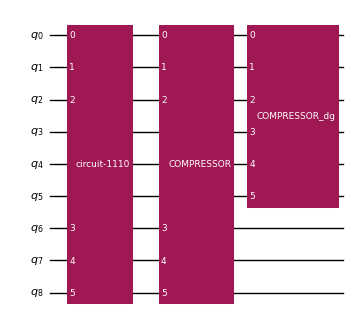

In [15]:
circuit = complete_circuit(
    BaaLowRankInitialize(
        typical_state,
        opt_params={
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': baa_strategy,
            'use_low_rank': use_low_rank
        }
    ),
    compressor,
    decompressor
)
# Draw the circuit diagram.
circuit.draw('mpl', scale=0.5, style="iqp")

In [16]:
print(get_cnot_count(circuit))

127


### Run the experiment without optimization

0 - Recovered state fidelity = 0.7802487799868251


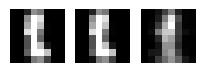

1 - Recovered state fidelity = 0.6580863856337054


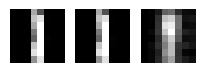

2 - Recovered state fidelity = 0.7221255616414265


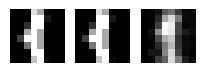

3 - Recovered state fidelity = 0.43914459563845215


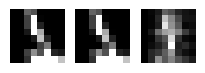

4 - Recovered state fidelity = 0.44376364996911116


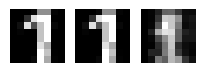

5 - Recovered state fidelity = 0.8578069472346521


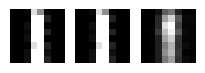

6 - Recovered state fidelity = 0.4436431469497584


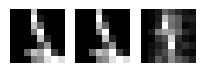

7 - Recovered state fidelity = 0.6864355612273615


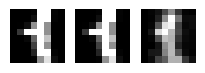

8 - Recovered state fidelity = 0.7863645515602532


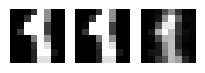

9 - Recovered state fidelity = 0.5867256087613125


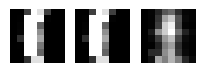

10 - Recovered state fidelity = 0.7604267642403925


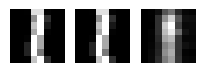

11 - Recovered state fidelity = 0.7034213168547369


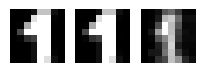

12 - Recovered state fidelity = 0.54680864263509


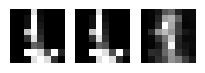

13 - Recovered state fidelity = 0.87534829363053


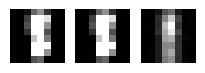

14 - Recovered state fidelity = 0.82050518302179


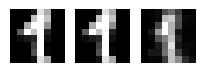

15 - Recovered state fidelity = 0.6283955209885989


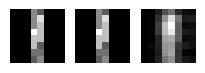

16 - Recovered state fidelity = 0.39418215331588735


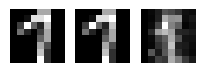

17 - Recovered state fidelity = 0.26195952974797226


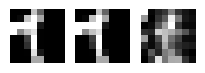

18 - Recovered state fidelity = 0.6346303918793992


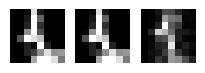

19 - Recovered state fidelity = 0.2121256923347075


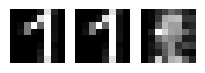

In [17]:
fidelities[0], figures[0] = experiment(
    test_input,
    compressor,
    decompressor,
    verbose=2
)

***
## Experiment with optimization 1
***
This optimization is based on the conservation of entropy.
As we are dealing with a pure state (Alice's side), our goal is to produce an initial state of zero entropy (or close to zero) on Bob's side.

### Constructs the set of gates to initialize the mixed-states.

In [18]:
# Applies the compression process to each of the train samples,
# calculates the correspondent trash state,
# and stores the correspondent mixed state initializer gate.

references_1 = []
for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
    initializer = BaaLowRankInitialize(
        test_sample,
        opt_params={
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': baa_strategy,
            'use_low_rank': use_low_rank
        }
    )

    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    trash_state = partial_trace(Statevector(circuit), compressor.latent_qubits)
    references_1.append([
        MixedInitialize(
            trash_state.data.T,
            classical=True,
            reset=False,
            initializer=BaaLowRankInitialize,
            opt_params={
                'max_fidelity_loss': max_fidelity_loss,
                'strategy': baa_strategy,
                'use_low_rank': use_low_rank
            }
        )
    ])

### Draw an example of the reference state initializer

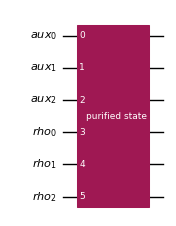

In [19]:
references_1[0][0].definition.draw('mpl', scale=0.5, style="iqp")

### Draws an example of the complete circuit

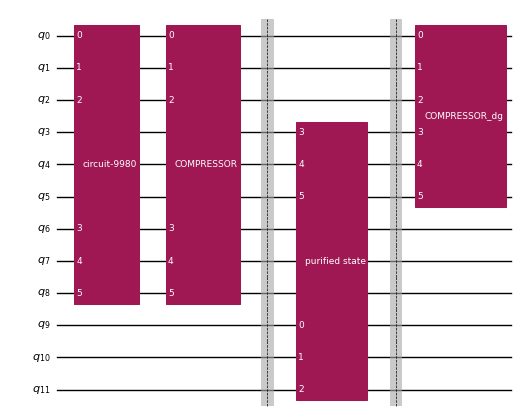

In [20]:
circuit = complete_circuit(
    BaaLowRankInitialize(
        typical_state,
        opt_params={
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': baa_strategy,
            'use_low_rank': use_low_rank
        }
    ),
    compressor,
    decompressor,
    references_1[0]
)
# Draw an example of the circuit.
circuit.draw('mpl', scale=0.5, style="iqp")

In [21]:
print(get_cnot_count(circuit))

174


## Optimized experiment:
Uses the exact trash state as the reference state.
This relies on classical communication, as the trash state must be transmited between Alice and Bob for each execution.

In [22]:
fidelities[1], figures[1] = experiment(
    test_input,
    compressor,
    decompressor,
    references=references_1,
    verbose=1
)

0 - Recovered state fidelity = 0.7864364281970281
1 - Recovered state fidelity = 0.6500795374298759
2 - Recovered state fidelity = 0.7159105233143815
3 - Recovered state fidelity = 0.4769763181226349
4 - Recovered state fidelity = 0.44206898258501537
5 - Recovered state fidelity = 0.8641057045919529
6 - Recovered state fidelity = 0.4509201639716751
7 - Recovered state fidelity = 0.6787276450009018
8 - Recovered state fidelity = 0.7848625145871357
9 - Recovered state fidelity = 0.5654751657205411
10 - Recovered state fidelity = 0.7693372142351576
11 - Recovered state fidelity = 0.697683867910326
12 - Recovered state fidelity = 0.5865370275977737
13 - Recovered state fidelity = 0.895606902410606
14 - Recovered state fidelity = 0.8248042413686244
15 - Recovered state fidelity = 0.6127298276797147
16 - Recovered state fidelity = 0.40560318112269855
17 - Recovered state fidelity = 0.2173313779567897
18 - Recovered state fidelity = 0.6296730144813347
19 - Recovered state fidelity = 0.1931067

***
## Experiment with optimization 2
***
This optimization reduces the cost of the previous one by relying on single-qubit tomography. That way, the cost of the tomography is linear on the number of trash qubits, O(n_t), and the cost of the classical communication is also O(n_t).

### Constructs the set of gates to initialize the mixed-states.

In [23]:
references_2 = []

for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
    initializer = BaaLowRankInitialize(
        test_sample,
        opt_params={
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': baa_strategy,
            'use_low_rank': use_low_rank
        }
    )

    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    single_qubit_initializers = []
    for trash_qubit in compressor.trash_qubits:
        trash_qubits = list(set(compressor.trash_qubits) - set([trash_qubit]))
        trash_state = partial_trace(Statevector(circuit), trash_qubits + compressor.latent_qubits)
        single_qubit_initializers.append(
            MixedInitialize(
                trash_state.data.T,
                classical=True,
                reset=False
            )
        )

    references_2.append(single_qubit_initializers)

### Draw an example of the reference state initializer

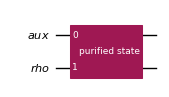

In [24]:
references_2[0][0].definition.draw('mpl', scale=0.5, style="iqp")

### Draw an example of the complete circuit

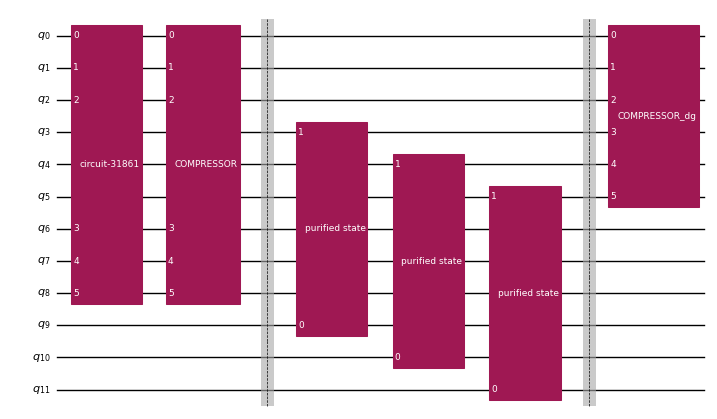

In [25]:
circuit = complete_circuit(
    BaaLowRankInitialize(
        typical_state,
        opt_params={
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': baa_strategy,
            'use_low_rank': use_low_rank
        }
    ),
    compressor,
    decompressor,
    references_2[0]
)
# Draw an example of the circuit.
circuit.draw('mpl', scale=0.5, style="iqp")

In [26]:
print(get_cnot_count(circuit))

130


## Optimized experiment:
Uses the single-qubit trash states as the reference state.
This relies on classical communication, as the trash state must be transmited between Alice and Bob for each execution, but the cost is only O(n_t).

In [27]:
fidelities[2], figures[2] = experiment(
    test_input,
    compressor,
    decompressor,
    references=references_2,
    verbose=1
)

0 - Recovered state fidelity = 0.7801038340141768
1 - Recovered state fidelity = 0.6218517665921788
2 - Recovered state fidelity = 0.7042789168067046
3 - Recovered state fidelity = 0.346237917210027
4 - Recovered state fidelity = 0.3816115094783057
5 - Recovered state fidelity = 0.8590668200792478
6 - Recovered state fidelity = 0.37663973638081333
7 - Recovered state fidelity = 0.6657071837574923
8 - Recovered state fidelity = 0.7730535178633274
9 - Recovered state fidelity = 0.5521164944023798
10 - Recovered state fidelity = 0.7511674801485746
11 - Recovered state fidelity = 0.6826717156052029
12 - Recovered state fidelity = 0.516004026070911
13 - Recovered state fidelity = 0.8794838954360155
14 - Recovered state fidelity = 0.8208367549119019
15 - Recovered state fidelity = 0.5782492164860924
16 - Recovered state fidelity = 0.33217667992146493
17 - Recovered state fidelity = 0.19632170186176315
18 - Recovered state fidelity = 0.6036961591270825
19 - Recovered state fidelity = 0.126860

***
## Summary
***

In [28]:
zip_fidelities = list(zip(fidelities[0],fidelities[1],fidelities[2]))
for i, (item1, item2, item3) in enumerate(zip_fidelities):
    print(i, '-', item1, item2, item3)

print('\navg', *np.average(zip_fidelities, axis=0))
print('min', *np.min(zip_fidelities, axis=0))
print('max', *np.max(zip_fidelities, axis=0))
print('std', *np.std(zip_fidelities, axis=0))

0 - 0.7802487799868251 0.7864364281970281 0.7801038340141768
1 - 0.6580863856337054 0.6500795374298759 0.6218517665921788
2 - 0.7221255616414265 0.7159105233143815 0.7042789168067046
3 - 0.43914459563845215 0.4769763181226349 0.346237917210027
4 - 0.44376364996911116 0.44206898258501537 0.3816115094783057
5 - 0.8578069472346521 0.8641057045919529 0.8590668200792478
6 - 0.4436431469497584 0.4509201639716751 0.37663973638081333
7 - 0.6864355612273615 0.6787276450009018 0.6657071837574923
8 - 0.7863645515602532 0.7848625145871357 0.7730535178633274
9 - 0.5867256087613125 0.5654751657205411 0.5521164944023798
10 - 0.7604267642403925 0.7693372142351576 0.7511674801485746
11 - 0.7034213168547369 0.697683867910326 0.6826717156052029
12 - 0.54680864263509 0.5865370275977737 0.516004026070911
13 - 0.87534829363053 0.895606902410606 0.8794838954360155
14 - 0.82050518302179 0.8248042413686244 0.8208367549119019
15 - 0.6283955209885989 0.6127298276797147 0.5782492164860924
16 - 0.39418215331588735

0


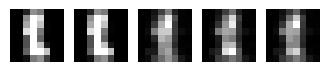

1


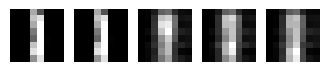

2


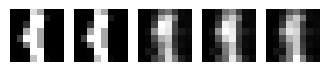

3


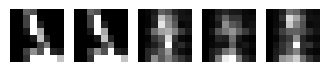

4


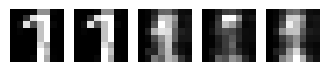

5


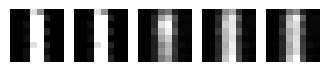

6


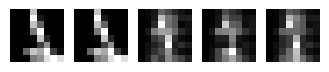

7


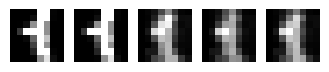

8


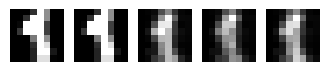

9


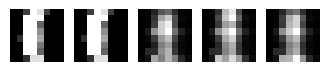

10


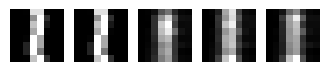

11


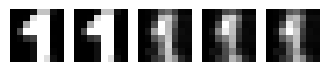

12


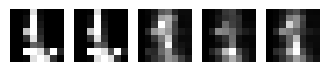

13


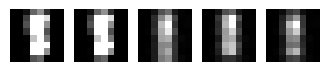

14


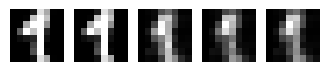

15


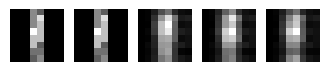

16


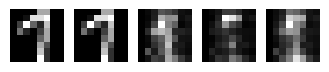

17


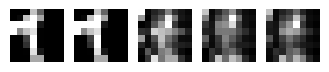

18


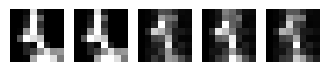

19


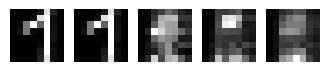

In [29]:
for i, (item1, item2, item3) in enumerate(zip(figures[0],figures[1],figures[2])):
    print(i)
    plot_digits([item1[0], item1[1], item1[2], item2[2], item3[2]], n_qubits)